## Q6 Multiple Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stan
import pandas as pd
import arviz as az
import seaborn as sns
import nest_asyncio
nest_asyncio.apply()

Below is the same model used for Q5

In [2]:
program_code = """
data {
    int<lower=1> N; // training count
    int<lower=1> K; // weight count
    int<lower=1> T; // test count
    vector[N] charges; // training output
    matrix[N,K] params; // training input
    matrix[K,K] covariance; // covaraiance for multi_norm
    matrix[T,K] test_params; // testing input
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ inv_gamma(3.0, 1.0);
    alpha ~ normal(0, 10.0);
    beta ~ multi_normal([0.0, 0.0, 0.0], covariance);
    
    // Likelihood
    for (n in 1:N) {
        charges[n] ~ normal(alpha + (params[n] * beta), sigma);
    }
}

generated quantities {
    vector[T] pred_signal;
    for (n in 1:T) {
        pred_signal[n] = normal_rng(alpha + (test_params[n] * beta), sigma);
    }
}

"""

Load data and normalize

In [3]:
samples = pd.read_csv("insurance.csv", delimiter=',')
N = len(samples)
K = 3

parameters = samples[["age", "bmi", "children"]]
parameters = (parameters - parameters.mean()) / parameters.std()
labels = samples["charges"]
labels = (labels - labels.mean()) / labels.std()

cutoff = int(N*0.70)
training_params, test_params = parameters.iloc[:cutoff], parameters.iloc[cutoff:]
training_labels, test_labels = labels.iloc[:cutoff], labels.iloc[cutoff:]

data = {
    'N' : cutoff,
    'K' : K,
    'T' : len(labels) - cutoff,
    'charges' : training_labels.to_list(),
    'params' : training_params.to_numpy(),
    'covariance' : np.eye(K) * 3.0,
    'test_params' : test_params.to_numpy()
}

Compile model

In [4]:
model = stan.build(program_code=program_code, data=data)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


Sample fitted distribution

In [5]:
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=1000)
results = fit.to_frame()

Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  10% (800/8000)
Sampling:  14% (1100/8000)
Sampling:  22% (1800/8000)
Sampling:  44% (3500/8000)
Sampling:  65% (5200/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000372 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.72 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000342 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000272 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.72 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000291 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.91 seconds.
  Adjust your expectations accordingly!
  Inform

Quick summary to verify everything worked

In [6]:
az.summary(fit, var_names=['alpha', 'sigma', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.031,0.029,-0.088,0.021,0.0,0.0,4851.0,2968.0,1.0
sigma,0.928,0.022,0.887,0.968,0.0,0.0,4687.0,2672.0,1.0
beta[0],0.301,0.030,0.245,0.357,0.0,0.0,4886.0,2981.0,1.0
beta[1],0.159,0.032,0.100,0.218,0.0,0.0,4651.0,3123.0,1.0
beta[2],0.035,0.030,-0.023,0.088,0.0,0.0,5379.0,3304.0,1.0


Calculate RMSE and visualize distribution

/home/chase/miniconda3/envs/cog/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 0, 'RMSE'), Text(0.5, 1.0, 'Predictive RMSE'), Text(0, 0.5, '')]

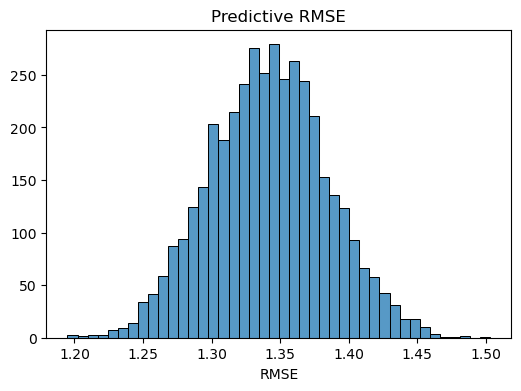

In [10]:
f, ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.sqrt(np.mean((results.iloc[:, 12:] - test_labels.values) ** 2, axis=1)), ax=ax)
ax.set(xlabel="RMSE", title="Predictive RMSE", ylabel="")

### Discussion
How good are your predictions?  
The predictions had an 'ok' result and can be improved with more complex models. For certain, we were able to identify the most important parameter within the subset (age, bmi, num children).  

What information did you lose by computing the predictive means?  
Using predictive means, we are losing out on tracking individual errors. Individual prediction-error pairing can assist in identifying specific areas where the model is failing

How could you possibly propagate the uncertainty information encoded in the predictive distribution to obtain a distribution over the test RMSE values?  
Currently, the entire data analysis is only completed once. If we were to resample and recalculate the RMSE for reallocated train and test sets, we can create a distribution of RMSEs. This this, we can observe uncertainty within the model 